Sara Rezaei - 98222043


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#define 5 I_current types
def I_value(time , I_type , I_init):

  t = len(time)
  I0 = []
  I1 = []
  I2 = []
  I3 = []
  I4 = []
   
  if(I_type == 1):      #step_function
    I0 = np.zeros(t)    
    I0[1000:3000] = I_init  
    I0[3000:] = I_init*3
    return I0; 

  for i in range(0, t):

      I = I_init     #constant
      I1.append(I)
        
      I = I_init*i/1000    #linear
      I2.append(I)

      I = ((math.sin(i/50)+2)*0.05) 
      I3.append(I)

      I = ((math.exp(i/2000)+1)*0.05)   
      I4.append(I)
    
  I = [I0,I1,I2,I3,I4]

  return I[I_type-1]

# LIF MODEL

τ .(du/dt) = -(u(t) - u_rest) + R.I(t)

if u(t) = Threshold => Fire + Reset ( u = u_reset )

In [3]:
class LIF:

  def __init__(self, I_type):
    self.I_type = I_type

  def LIF(self, I_init, gl, Cm):

    U_rest      =   -0.065                  
    U_reset     =   -0.065
    thresh  =   -0.050                      
    tau =  Cm/gl
    T       =   0.100      # total simulation length [s]                 
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    # VOLTAGE
    U       =   np.empty(len(time))         
    U[0]    =   U_rest                      
    
    I = I_value(time, self.I_type ,I_init)

    spikes  =   0                           
    t = time[1000]
    ts = 0
    
    for i in range(1, len(time)):
        U[i] = (((U_rest - U[i-1]) + I[i]/gl)*dt)/tau + U[i-1]
        
        # in case we exceed threshold
        if U[i] > thresh:
            U[i-1] = 0.04   
            U[i] = U_reset  
            ts = time[i]-t
            t = time[i]
            spikes += 1     
            
    
    return U , ts ,I

  def LIF_FI_curve(self,g,C):
    F = []
    #compute Frequency based on different amount of constant current I
    I_inp= np.arange(0,0.1001,0.0001)
    for i in I_inp:
        U,ts,I = self.LIF(I_init=i , gl=g, Cm=C) 
        F.append(1/(ts)) if ts>0 else F.append(ts)



    fig1 = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(10, 7))
    plt.subplot(111)
    plt.title("Interactive Leaky Integrate-and-Fire Neuron Model")
    fig1.subplots_adjust(left=0.1, bottom=0.32)

    # plot lines
    plt.plot(I_inp,F,'r--',label="F-I curve")
    plt.legend(loc="lower right")

    # add axis labels
    plt.ylabel("f (1/T)")
    plt.xlabel("I (V)") 


  def LIF_Model_plot(self,I_init,gl_init,Cm_init):
    # time parameters for plotting
    T       =   0.100                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]

    # update functions for lines
    U , ts , I= self.LIF(I_init, gl_init, Cm_init)
    thresh = np.zeros(len(time))
    thresh[0:5001] = -0.05

    # Plotting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(14, 8))
    plt.subplot(111)
    plt.title("Leaky Integrate-and-Fire Neuron Model")
    fig.subplots_adjust(left=0.1, bottom=0.32)
    plt.plot(time,thresh,'r--' ,label="thresh")[0]
    plt.plot(time, U, label="Potential:U")[0]
    plt.plot(time, I, label="Applied Current:I")[0]
    plt.legend(loc="upper left")
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    

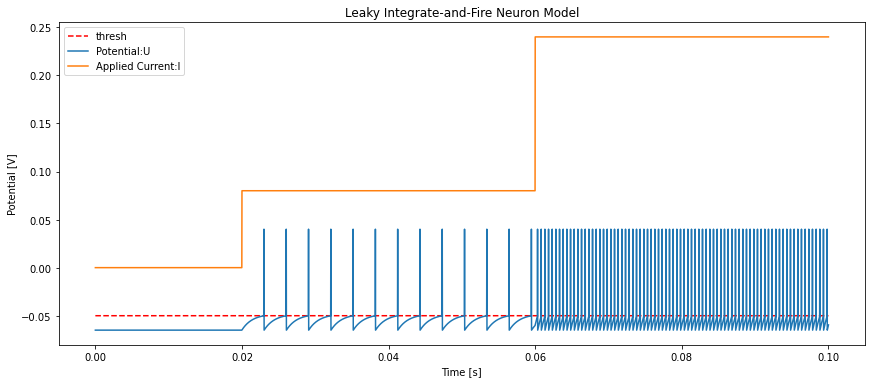

In [4]:
lif = LIF(1)
lif.LIF_Model_plot(0.08,4.7,0.00675)


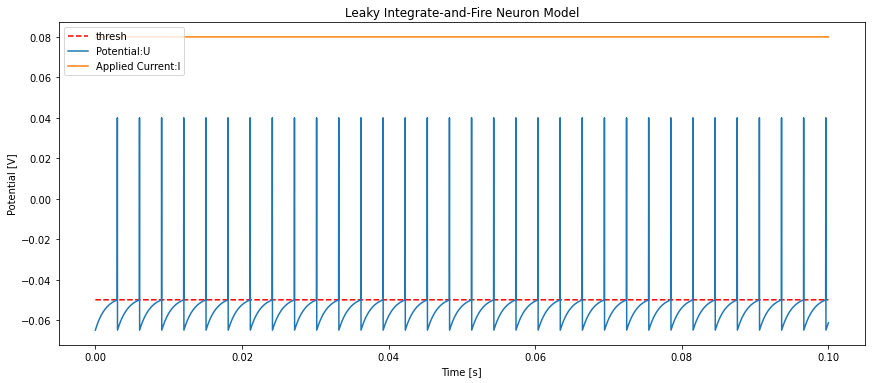

In [5]:
lif = LIF(2)
lif.LIF_Model_plot(0.08,4.7,0.0067)


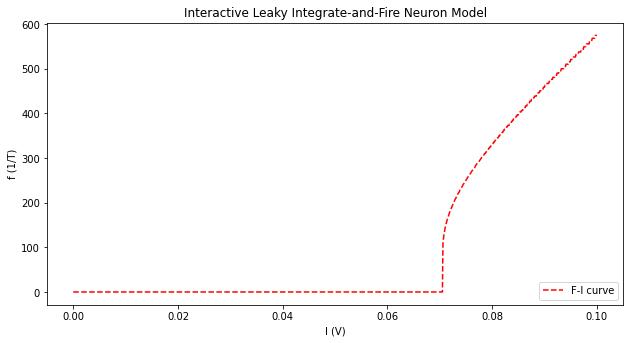

In [6]:
lif.LIF_FI_curve(4.7,0.0067)

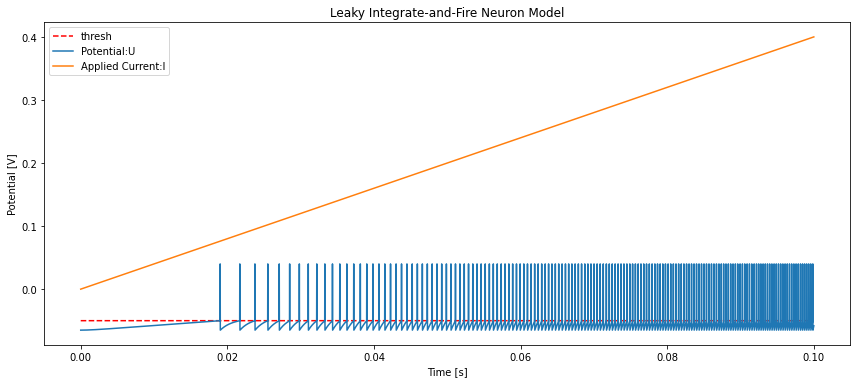

In [7]:
lif = LIF(3)
lif.LIF_Model_plot(0.08,4.7,0.0067)


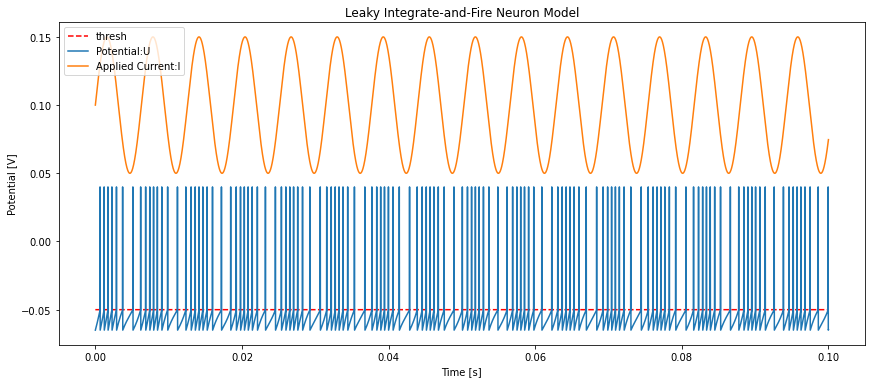

In [8]:
lif = LIF(4)
lif.LIF_Model_plot(0.005 ,0.16 ,0.005)


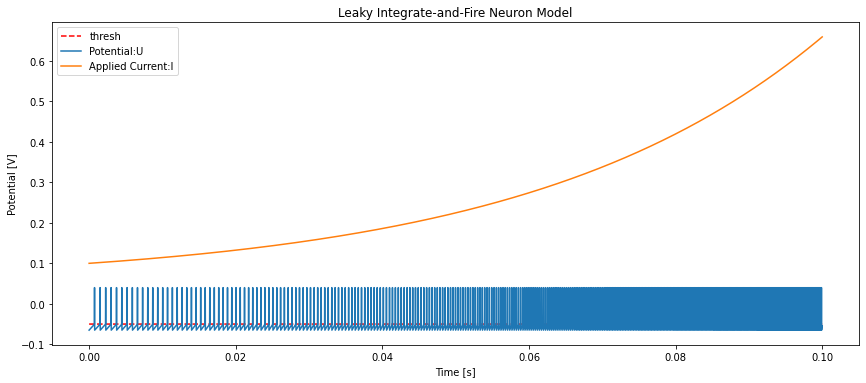

In [9]:
lif = LIF(5)
lif.LIF_Model_plot(0.005 ,0.16 ,0.005)


# ALIF MODEL

τ .(du/dt) = -(u(t) - u_rest) − Rw + R.I(t)

τ_w.(dw/dt)= a(u − u_rest) − w + b.τ_w ∑ δ( t − t_f )

if u(t) = Threshold => Fire + Reset ( u = u_reset )

In [10]:
class ALIF:

  def __init__(self, I_type):
    self.I_type = I_type

  def ALIF(self, I_init, gl, Cm ):
    U_rest      =   -0.065                      
    U_reset     =   -0.065
    thresh  =   -0.05                      
    delta = 0.01                             #is the sharpness parameter
    tau =  Cm/gl
    tau_w = 0.00001                          
    a = 0.01                                 #firing patterns parameter
    b =250                                   #firing patterns parameter
    # TIME
    T       =   0.100                       
    dt      =   0.00002                     
    time    =   np.arange(0, T+dt, dt)   
    # VOLTAGE
    U       =   np.empty(len(time))         # array for saving Voltage history
    U[0]    =   U_rest                      # set initial to resting potential
    # CURRENT
    I = I_value(time, self.I_type ,I_init)
    
    # Adaptation weights
    W = np.zeros(len(time))
    
    
    spikes  =   0                           # counter for number of spikes
    for i in range(1, len(time)): 
        
        weight =W[i-1]/gl *bool(spikes)
        U[i]=(((U_rest-U[i-1])+I[i]/gl-weight)*dt)/tau+U[i-1]
        
        if( I[i] > 0):    
            W[i] = ((a*(U[i-1] -U_rest) - W[i-1] + b* tau_w*spikes)*dt)/tau_w + W[i-1]
        
        # in case we exceed threshold
        if U[i] >= thresh :
            U[i-1] = 0.04   # set the last step to spike value
            U[i] = U_reset  # current step is resting membrane potential
            spikes += 1     # count spike
            
    
    return U , spikes , I


  def ALIF_FI_curve(self,g,C):
    F = []
    I_inp= np.arange(0,1,0.001)
    for i in I_inp:
        U,f,I= self.ALIF(I_init=i , gl=g, Cm=C) 
        F.append(f+0.005)



    fig1 = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(10, 7))
    plt.subplot(111)
    plt.title("Interactive Leaky Integrate-and-Fire Neuron Simulation")
    fig1.subplots_adjust(left=0.1, bottom=0.32)

    # plot lines
    plt.plot(I_inp,F,'r--',label="F-I curve")
    plt.legend(loc="lower right")

    # add axis labels
    plt.ylabel("f (1/T)")
    plt.xlabel("I (V)") 


  def ALIF_Model_plot(self,I_init,gl_init,Cm_init):
    # time parameters for plotting
    T       =   0.100                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]

    # update functions for lines
    U , f, I= self.ALIF(I_init, gl_init, Cm_init)
    thresh = np.zeros(len(time))
    thresh[0:5001] = -0.04

    # Plotting
    fig = plt.figure("Adaptive exponential leaky Integrate-and-Fire Neuron Model", figsize=(14, 7))
    plt.subplot(111)
    plt.title("Adaptive exponential leaky Integrate-and-Fire Neuron Model")
    fig.subplots_adjust(left=0.1, bottom=0.32)
    plt.plot(time,thresh,'r--' ,label="thresh")[0]
    plt.plot(time, U, label="Potential:U")[0]
    plt.plot(time, I, label="Applied Current:I")[0]
    plt.legend(loc="upper left")
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
 
    

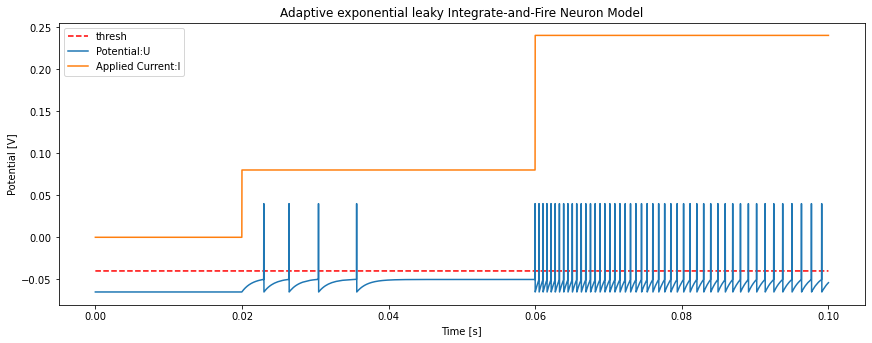

In [11]:
alif = ALIF(1)
alif.ALIF_Model_plot(0.08,4.7,0.0067)

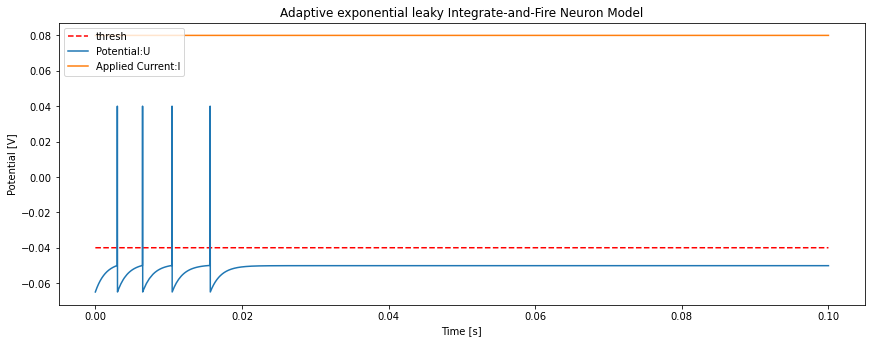

In [12]:
alif = ALIF(2)
alif.ALIF_Model_plot(0.08,4.7,0.0067)

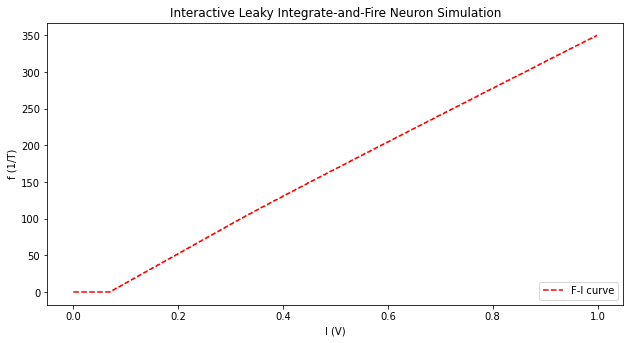

In [13]:
alif.ALIF_FI_curve(4.7,0.0067)

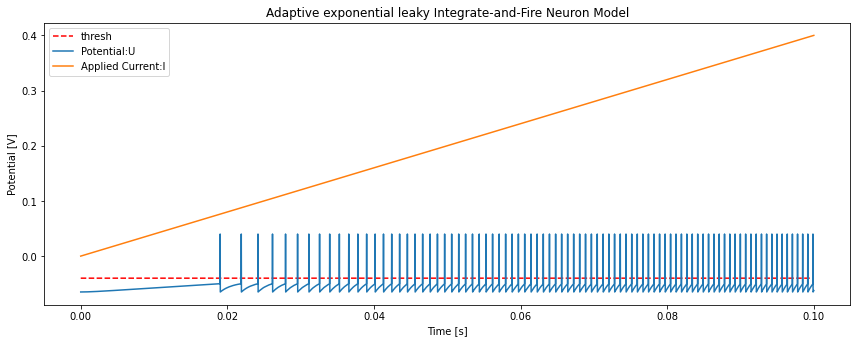

In [14]:
alif = ALIF(3)
alif.ALIF_Model_plot(0.08,4.7,0.0067)

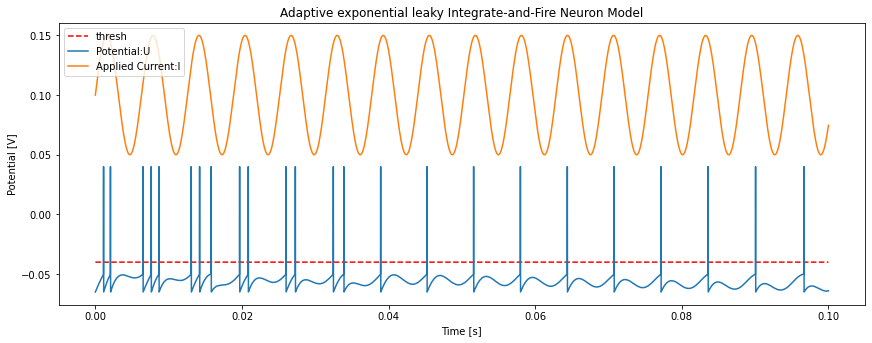

In [15]:
alif = ALIF(4)
alif.ALIF_Model_plot(0.08,4.7,0.0067)

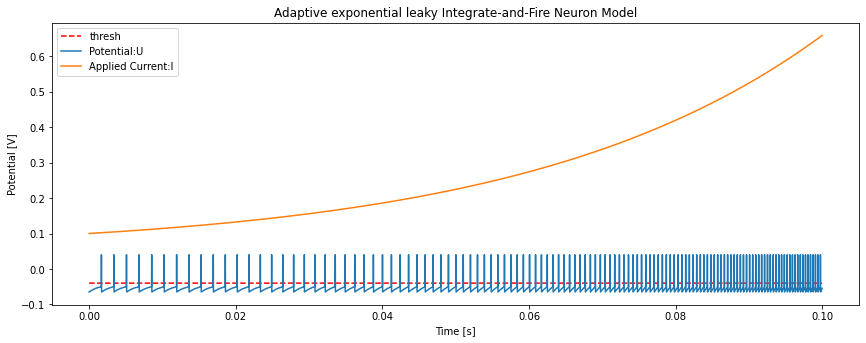

In [16]:
alif = ALIF(5)
alif.ALIF_Model_plot(0.08,4.7,0.0067)

# AELIF MODEL
τ.(du/dt) = = −( u(t) − u_rest ) + ∆T exp((u − θ_rh)/∆T) − Rw + R·I(t) 


τw.(dw/dt)= a(u(t) − u_rest ) − w + b.τ_w ∑ δ( t − t_f )


if u(t) = Threshold => Fire + Reset ( u = u_reset )

In [17]:
class AELIF:

  def __init__(self, I_type):
    self.I_type = I_type

  def AELIF(self, I_init, gl, Cm ):
    U_rest      =   -0.065                      
    U_reset     =   -0.065
    thresh  =   -0.04                      
    delta = 0.01                             #is the sharpness parameter
    tau =  Cm/gl
    tau_w = 0.00001                          
    a = 0.01                                 #firing patterns parameter
    b =250                                   #firing patterns parameter
    # TIME
    T       =   0.100                       
    dt      =   0.00002                     
    time    =   np.arange(0, T+dt, dt)   
    # VOLTAGE
    U       =   np.empty(len(time))         # array for saving Voltage history
    U[0]    =   U_rest                      # set initial to resting potential
    # CURRENT
    I = I_value(time, self.I_type ,I_init)
    # Adaptation weights
    W = np.zeros(len(time))
    
    
    spikes  =   0                           # counter for number of spikes
    for i in range(1, len(time)): 
        
        weight =W[i-1]/gl *bool(spikes)
        U[i]=(((U_rest-U[i-1])+delta*math.exp((U[i-1]-thresh)/delta)+I[i]/gl-weight)*dt)/tau+U[i-1]
        
        if( I[i] > 0):    
            W[i] = ((a*(U[i-1] -U_rest) - W[i-1] + b* tau_w*spikes)*dt)/tau_w + W[i-1]
        
        # in case we exceed threshold
        if U[i] >= 0.04:
            U[i-1] = 0.04   # set the last step to spike value
            U[i] = U_reset  # current step is resting membrane potential
            spikes += 1     # count spike
            
    
    return U , spikes , I


  def AELIF_FI_curve(self,g,C):
    F = []
    #compute Frequency based on different amount of constant current I by using number of spikes
    I_inp= np.arange(0,1,0.001)
    for i in I_inp:
        U,f,I= self.AELIF(I_init=i , gl=g, Cm=C) 
        F.append(f+0.005)



    fig1 = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(10, 7))
    plt.subplot(111)
    plt.title("Interactive Leaky Integrate-and-Fire Neuron Simulation")
    fig1.subplots_adjust(left=0.1, bottom=0.32)

    # plot lines
    plt.plot(I_inp,F,'r--',label="F-I curve")
    plt.legend(loc="lower right")

    # add axis labels
    plt.ylabel("f (1/T)")
    plt.xlabel("I (V)") 


  def AELIF_Model_plot(self,I_init,gl_init,Cm_init):
    # time parameters for plotting
    T       =   0.100                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]

    # update functions for lines
    U , f, I= self.AELIF(I_init, gl_init, Cm_init)
    thresh = np.zeros(len(time))
    thresh[0:5001] = -0.04

    # Plotting
    fig = plt.figure("Adaptive exponential leaky Integrate-and-Fire Neuron Model", figsize=(14, 7))
    plt.subplot(111)
    plt.title("Adaptive exponential leaky Integrate-and-Fire Neuron Model")
    fig.subplots_adjust(left=0.1, bottom=0.32)
    plt.plot(time,thresh,'r--' ,label="thresh")[0]
    plt.plot(time, U, label="Potential:U")[0]
    plt.plot(time, I, label="Applied Current:I")[0]
    plt.legend(loc="upper left")
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
 
    

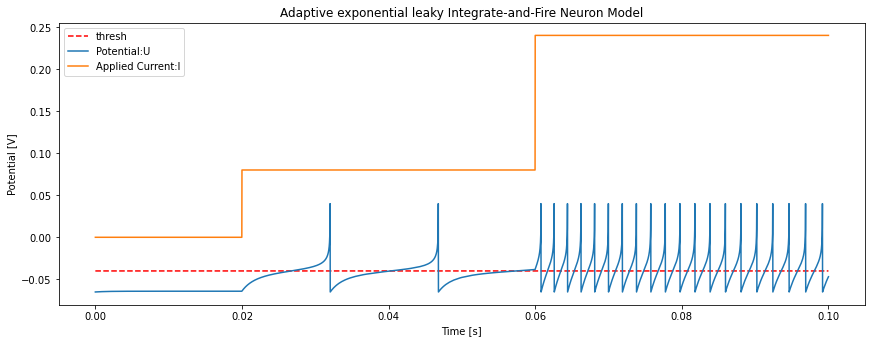

In [18]:
aelif = AELIF(1)
aelif.AELIF_Model_plot(0.08,4.7,0.0067)

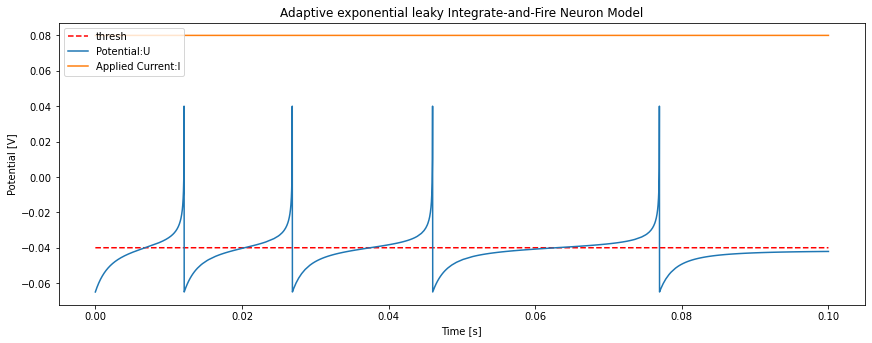

In [19]:
aelif = AELIF(2)
aelif.AELIF_Model_plot(0.08,4.7,0.0067)

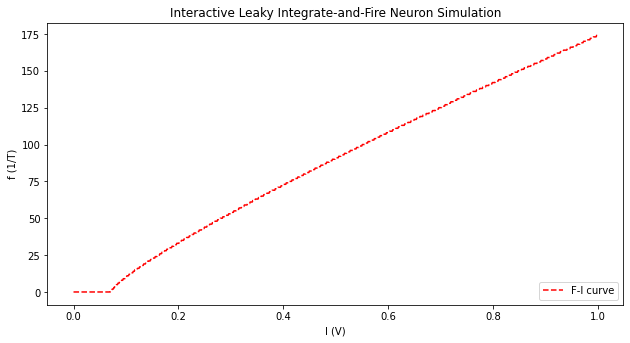

In [20]:
aelif.AELIF_FI_curve(4.7,0.0067)

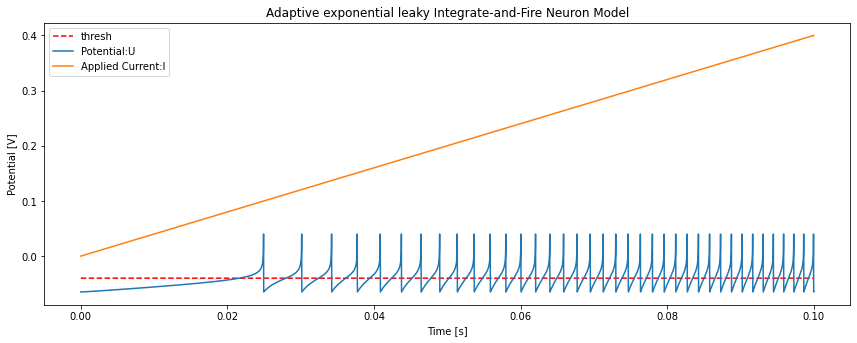

In [21]:
aelif = AELIF(3)
aelif.AELIF_Model_plot(0.08,4.7,0.0067)

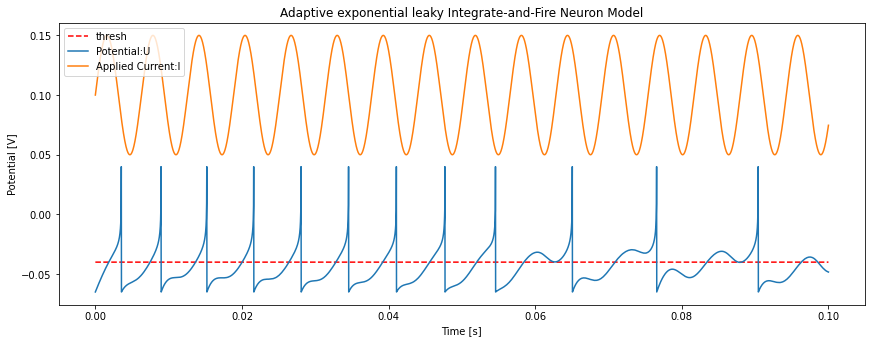

In [22]:
aelif = AELIF(4)
aelif.AELIF_Model_plot(0.08,4.7,0.0067)

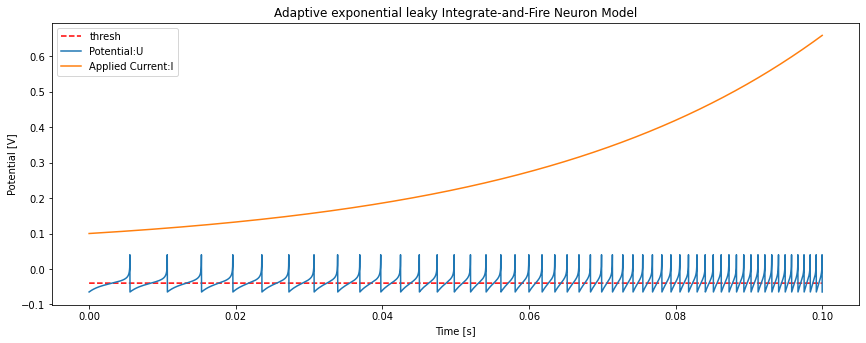

In [23]:
aelif = AELIF(5)
aelif.AELIF_Model_plot(0.08,4.7,0.0067)